### GEOG 490 Spatial Optimization
### Q1 (5%).

A company makes two products (X and Y) using two machines (A and B). Each unit of X that is produced requires 40 minutes processing time on machine A and 25 minutes processing time on machine B. Each unit of Y that is produced requires 25 minutes processing time on machine A and 30 minutes processing time on machine B.

Available processing time on machine A is 45 hours and on machine B is 40 hours.

The demand for X is 30 units and for Y is 20 units. Company policy is to meet the demand but also maximize the combined sum of the units of X and the units of Y produced. Also note that machines only able to produce whole units (integer).

Formulate the problem of deciding how much of each product to make as a linear program.

Solve this linear program using pulp.


Along with the code, also report these values in your notebook:
- The objective value under optimality
- How many units of X will be produced under optimality
- How many units of Y will be produced under optimality
    

In [1]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pulp import *

In [4]:
#Declare decision variables
x1 = LpVariable("x1", lowBound=0,cat='Integer')
x2 = LpVariable("x2", lowBound=0,cat='Integer')

In [10]:
prob = LpProblem("Nutrition", LpMinimize)

In [11]:
#Objective function
prob += x1/40+(45-x1)/25 + x2/25+(40-x2)/30


TypeError: unsupported operand type(s) for /: 'LpVariable' and 'int'

In [12]:
#Add constraints
prob += x1/40 + x2/25 >= 30
prob += (45-x1)/25 + (40-x2)/30 >= 20

TypeError: unsupported operand type(s) for /: 'LpVariable' and 'int'

In [ ]:
#Solve the problem
prob.solve()

print("Status:", LpStatus[prob.status])

In [ ]:
# The minimized objective fuction
print("Objective: ",value(prob.objective), "dollars")

In [ ]:
print("The optimal amount to buy A is:", value(x1))

In [ ]:
print("The optimal amount to buy B is:", value(x2))

### Q2 (5%)

Solve a p-median problem to optimally place **5** covid testing sites with maximum accessibility for communties in  Chicago. 

You are given a shapefile *chicago_comm_pop.shp* within the zipped folder *chicago_comm_pop.zip*. 

The shapefile contains 77 Chicago communties with population attached (Hint: replace 159 in the demand and facility initializations to 77). 

Replicate what we did in the lab with the Geogrgia example, using the column *Total_Pop* as the demand along with the distance between communities to solve this p-median problem.


Along with the code, also report this in your notebook:
- What are the facility nodes that we want to place the testing sites?
- Map the facilities on top of the population map. Here is an example (color represents pop):


(attachment:image.png)
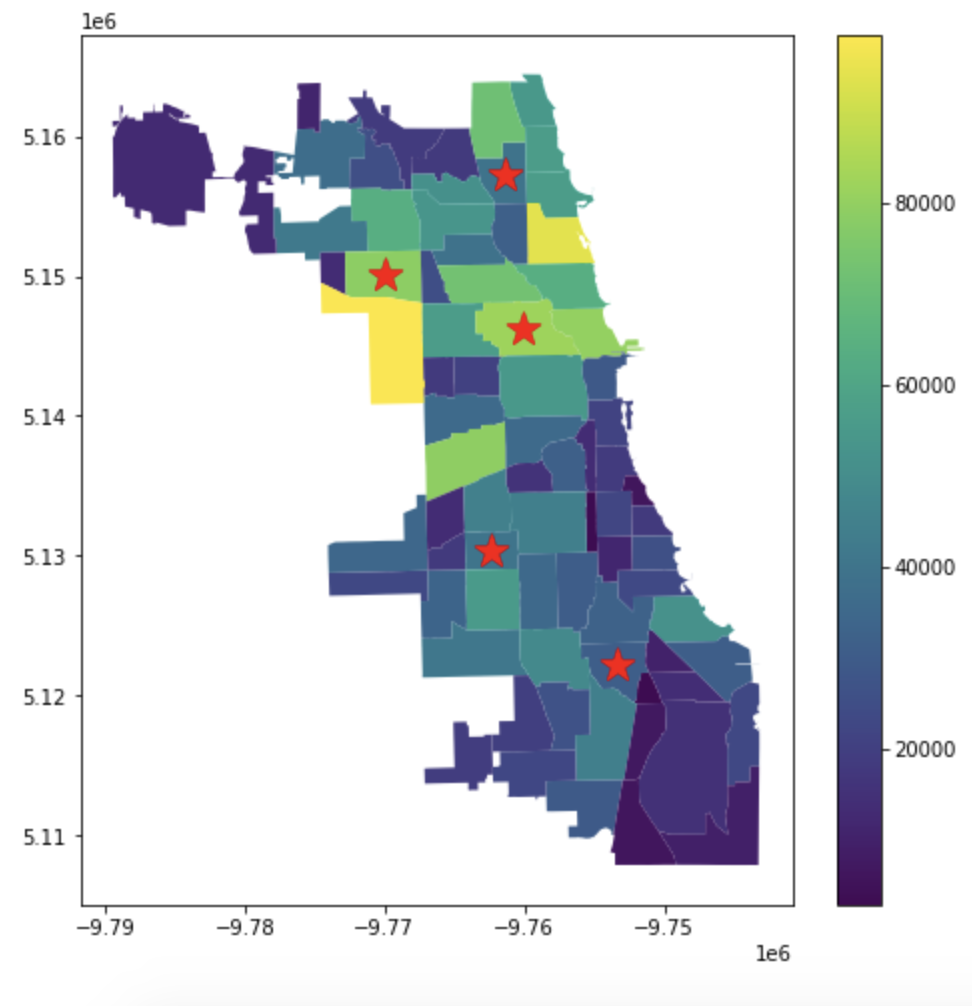


In [3]:
import numpy as np
import geopandas as gp


In [4]:
pip install libpysal

Note: you may need to restart the kernel to use updated packages.


In [5]:
from scipy.spatial.distance import cdist
import libpysal as ps
import matplotlib.pyplot as plt

ImportError: Numba needs NumPy 1.21 or less

In [22]:
chicago = gp.read_file("chicago_comm_pop") 

DriverError: chicago_comm_pop: No such file or directory

In [6]:
!unzip chicago_comm_pop

Archive:  chicago_comm_pop.zip
  inflating: chicago_comm_pop.cpg    
  inflating: chicago_comm_pop.dbf    
  inflating: chicago_comm_pop.prj    
  inflating: chicago_comm_pop.shp    
  inflating: chicago_comm_pop.shx    


In [7]:
chicago = gp.read_file("chicago_comm_pop.shp") 

In [8]:
#create a demand and a facilities variable, indicating the indices of each demand and facility.
#demand node: all counties
#facility: we could build facilities in some counties

demand = np.arange(0,159,1)
facilities = np.arange(0,159,1)

In [11]:
#Calculate a distance matrix d_ij (n by n)
coords = list(zip(chicago.centroid.x,chicago.centroid.y))
d = cdist(coords,coords) 

In [23]:
#the demand for each county (h_i) is the total populatoion 
h1 = chicago.TotPop90.values
h1

AttributeError: 'GeoDataFrame' object has no attribute 'TotPop90'

In [ ]:
# declare facilities variables
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary') 

In [ ]:
#Number of facilities to place
p = 3 #change this and re-run the code.

prob = LpProblem('P_Median', LpMinimize)

In [ ]:
# Objective function: Minimizing demand-distance weighted summed over all facilities and demand nodes 
# (h_i: demand at i; d_ij: distance between i and j)

prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

In [ ]:
# This constraint indicates we must place exactly p facilities

prob += sum([X[j] for j in facilities]) == p

In [ ]:
# This constraint implies that a demand node i can only be serviced by one facility

for i in demand: 
    prob += sum(Y[i][j] for j in facilities) == 1

In [ ]:
# This constraint implies that that demand node i 
# can be serviced by a facility at j only if there is a facility at j
# It implicitly removes situation when X[j] = 0 but Y[i][j] = 1 
# (node i is served by j but there is no facility at j)

for i in demand:
    for j in facilities: 
        prob +=  Y[i][j] <= X[j]

In [ ]:
%%time

# Solve the above problem
prob.solve()

print("Status:", LpStatus[prob.status])

In [ ]:
# The minimized total demand-distance. The unit is person * meter
print("Objective: ",value(prob.objective))

In [ ]:
# Print the facility node.
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: 
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

In [ ]:
# Get the geomerty of the facility nodes.
fac_loc = chicago.iloc[rslt,:]

In [ ]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

chicago.centroid.plot(ax=ax,markersize=georgia_shp.TotPop90/1000)#markersize is proportional to the population
fac_loc.centroid.plot(ax=ax,color="red",markersize=300,marker="*")

In [ ]:
from shapely.geometry import LineString, MultiLineString
lines = []
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: 
        left, right = (int(subV[1]), int(subV[2]))
        line = LineString([georgia_shp.iloc[left,:].geometry.centroid, chicago.iloc[right,:].geometry.centroid])
        lines.append(line)
gdf_lines = gp.GeoDataFrame(geometry=lines)

In [ ]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(8,8))

chicago.plot(ax=ax,column="TotPop90")#markersize is proportional to the population
chicago.centroid.plot(ax=ax,color="black")
gdf_lines.plot(ax=ax,color="white")
fac_loc.centroid.plot(ax=ax,color="red",markersize=500,marker="*",zorder=2)
plt.axis('off')

### Q3 (bonus credit 1%)

Change the p-median problem above to a p-center problem (p=5). Using the formulation in the lecture slides to find the minimized distance Q. Along with the code, report the optimal minimized Q value.